In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import dynamic_louvain
from multiprocessing import Pool
import bct
from numpy.random import default_rng
import pickle
import parameter_search
import random

In [2]:
figure_data = {}

In [3]:
def load_data(prefix):
    comms_filename = prefix + '.tcomms'
    comms_data = np.loadtxt(comms_filename,delimiter=' ')
    time_layers = list(set(comms_data[:,0]))
    comm_structure = []
    for i in time_layers:
        time_layer_i = comms_data[comms_data[:,0]==i]
        time_layer_i = time_layer_i[time_layer_i[:, 1].argsort()]
        comm_structure.append(time_layer_i[:,2])
    comm_structure = np.transpose(np.array(comm_structure))
    number_of_nodes,_ = comm_structure.shape

    
    graph_filename = prefix + '.tgraph'
    graph_data = np.loadtxt(graph_filename,delimiter=' ')
    time_layers = list(set(graph_data[:,3]))
    adj_ijl = []
    for i in time_layers:
        time_layer_i = graph_data[graph_data[:,3]==i]
        links = time_layer_i[:,0:2]
        edges = [(i,j) for i,j in links]
        G = nx.from_edgelist(edges)
        adj_matrix = nx.to_numpy_array(G,nodelist=list(range(number_of_nodes)))
        adj_ijl.append(adj_matrix)
    adj_ijl = np.array(adj_ijl)
    
    comm_structure = np.transpose(comm_structure)

    return adj_ijl,comm_structure

In [4]:
def bootstrap_replicas(data, replicas=100):
    mean_replicas = []
    data_length = len(data)
    for i in range(replicas):
        replica = random.choices(data, k=data_length)
        mean_replicas.append(np.mean(replica))
    return mean_replicas

def bootstrap_margins(data, n):
    test = bootstrap_replicas(data, replicas=n)
    lower_bound = np.percentile(test, 2.5)
    upper_bound = np.percentile(test, 97.5)
    mean = np.mean(test)
    return mean, lower_bound, upper_bound

In [5]:
omega_values = []
gamma_values = []
for sample in range(20):
    output_filename = 'StdGrow_search' + str(sample) + '.pck'
    with open(output_filename, 'rb') as f:
        output = pickle.load(f)
    gamma,omega = output[0][2]
    gamma_values.append(gamma)
    omega_values.append(omega)
    
gamma_values = np.array(gamma_values)
omega_values = np.array(omega_values)
mean_omega = np.mean(omega_values)

In [6]:
output_model = {}

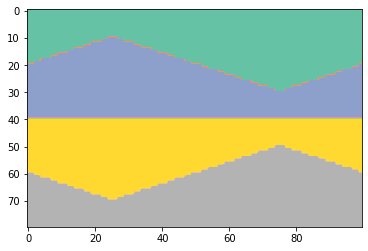

In [7]:
model = 'StdGrow'
adj_ijl, comm_structure = load_data(model)

plt.imshow(np.transpose(comm_structure),aspect='auto',cmap='Set2')
plt.show()

In [8]:
adj_matrix = adj_ijl
gamma_values_space=np.linspace(0.5,2.0,10)
parameters = [(adj_matrix, i, mean_omega) for i in gamma_values_space]
    
num_processors = 10
p=Pool(processes = num_processors)
output = p.starmap(dynamic_louvain.dynamic_louvain,parameters)
output_model.update({model: output})

In [9]:
mean, lower_bound, upper_bound = bootstrap_margins(gamma_values, 1000)
mean_gamma = mean
mean_gamma

1.174047901234568

In [10]:
mean_omega

0.8795610425240057

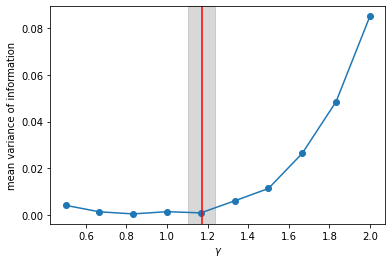

In [11]:
time_layers,_ = output[0][2].shape
var_info_ts = []
for i in range(10):
    q1 = output[i][2]
    q2 = comm_structure
    var_info = []
    for l in range(time_layers):
        var_info_aux,mutual_info = bct.partition_distance(q1[l,:], q2[l,:])
        var_info.append(var_info_aux)
    var_info_ts.append(np.mean(var_info))
plt.plot(gamma_values_space,var_info_ts,marker='o')
plt.axvline(x=mean,c='r')
plt.axvspan(lower_bound, upper_bound,color='grey',alpha=0.3)
plt.xlabel(r'$\gamma$')
plt.ylabel('mean variance of information')
plt.show()

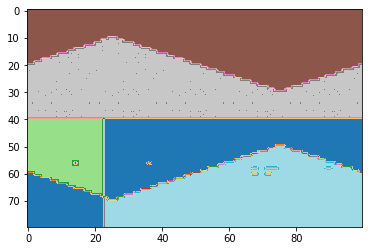

In [12]:
output = dynamic_louvain.dynamic_louvain(adj_matrix, mean_gamma, mean_omega)
comm_struct_result = output[2]
plt.imshow(np.transpose(comm_struct_result),aspect='auto',cmap='tab20')
plt.show()

In [95]:
figure_data.update({'Grow-Shrink':[gamma_values_space,var_info_ts,mean,lower_bound, upper_bound,comm_structure,comm_struct_result]})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


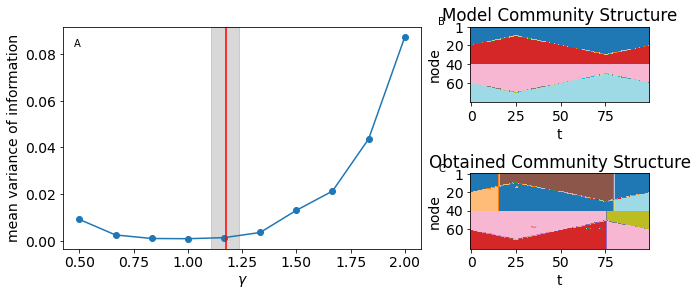

In [96]:
fig = plt.figure(constrained_layout=True,figsize=(9,4))
axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})

axs['Left'].plot(gamma_values_space,var_info_ts,marker='o')
axs['Left'].axvline(x=mean,c='r')
axs['Left'].axvspan(lower_bound, upper_bound,color='grey',alpha=0.3)
axs['Left'].set_xlabel(r'$\gamma$')
axs['Left'].set_ylabel('mean variance of information')
axs['Left'].text(0.05, 0.9, 'A', verticalalignment='bottom', 
         horizontalalignment='right', transform=axs['Left'].transAxes, fontsize=10)

axs['TopRight'].set_title('Model Community Structure')
axs['TopRight'].imshow(np.transpose(comm_structure),aspect='auto',cmap='tab20')
axs['TopRight'].set_yticks([0,19,39,59])
axs['TopRight'].set_yticklabels([1,20,40,60])
axs['TopRight'].set_xlabel('t')
axs['TopRight'].set_ylabel('node')
axs['TopRight'].text(-0.14, 1, 'B', verticalalignment='bottom', 
         horizontalalignment='right', transform=axs['TopRight'].transAxes, fontsize=10)

axs['BottomRight'].set_title('Obtained Community Structure')
axs['BottomRight'].imshow(np.transpose(comm_struct_result),aspect='auto',cmap='tab20')
axs['BottomRight'].set_yticks([0,19,39,59])
axs['BottomRight'].set_yticklabels([1,20,40,60])
axs['BottomRight'].set_xlabel('t')
axs['BottomRight'].set_ylabel('node')
axs['BottomRight'].text(-0.14, 1, 'C', verticalalignment='bottom', 
         horizontalalignment='right', transform=axs['BottomRight'].transAxes, fontsize=10)

plt.savefig('Fig_Grow.eps', format='eps')
plt.show()

In [117]:
omega_values = []
gamma_values = []
for sample in range(20):
    output_filename = 'StdMerge_search' + str(sample) + '.pck'
    with open(output_filename, 'rb') as f:
        output = pickle.load(f)
    gamma,omega = output[0][2]
    gamma_values.append(gamma)
    omega_values.append(omega)
    
gamma_values = np.array(gamma_values)
omega_values = np.array(omega_values)
mean_omega = np.mean(omega_values)

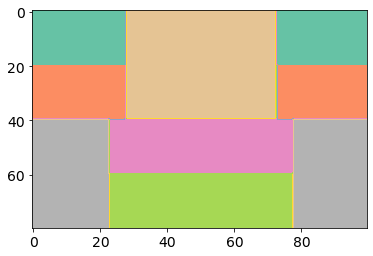

In [118]:
model = 'StdMerge'
adj_ijl, comm_structure = load_data(model)

plt.imshow(np.transpose(comm_structure),aspect='auto',cmap='Set2')
plt.show()

In [119]:
adj_matrix = adj_ijl
gamma_values_space=np.linspace(0.1,1.5,10)
parameters = [(adj_matrix, i, mean_omega) for i in gamma_values_space]
    
num_processors = 10
p=Pool(processes = num_processors)
output = p.starmap(dynamic_louvain.dynamic_louvain,parameters)
output_model.update({model: output})

In [120]:
mean, lower_bound, upper_bound = bootstrap_margins(gamma_values, 1000)
mean_gamma = mean

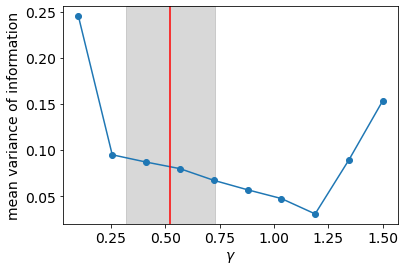

In [121]:
time_layers,_ = output[0][2].shape
var_info_ts = []
for i in range(10):
    q1 = output[i][2]
    q2 = comm_structure
    var_info = []
    for l in range(time_layers):
        var_info_aux,mutual_info = bct.partition_distance(q1[l,:], q2[l,:])
        var_info.append(var_info_aux)
    var_info_ts.append(np.mean(var_info))
plt.plot(gamma_values_space,var_info_ts,marker='o')
plt.axvline(x=mean,c='r')
plt.axvspan(lower_bound, upper_bound,color='grey',alpha=0.3)
plt.xlabel(r'$\gamma$')
plt.ylabel('mean variance of information')
plt.show()

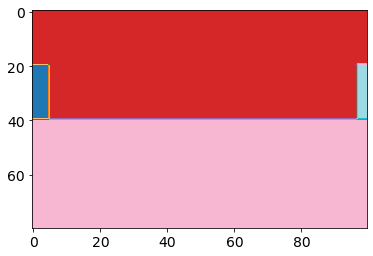

In [122]:
output = dynamic_louvain.dynamic_louvain(adj_matrix, mean_gamma, mean_omega)
comm_struct_result = output[2]
plt.imshow(np.transpose(comm_struct_result),aspect='auto',cmap='tab20')
plt.show()

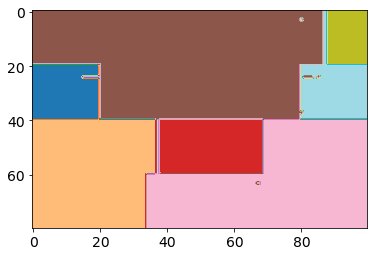

In [123]:
output = dynamic_louvain.dynamic_louvain(adj_matrix, 1.2, mean_omega)
comm_struct_result = output[2]
plt.imshow(np.transpose(comm_struct_result),aspect='auto',cmap='tab20')
plt.show()

In [103]:
figure_data.update({'Merge-Split':[gamma_values_space,var_info_ts,mean,lower_bound, upper_bound,comm_structure,comm_struct_result]})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


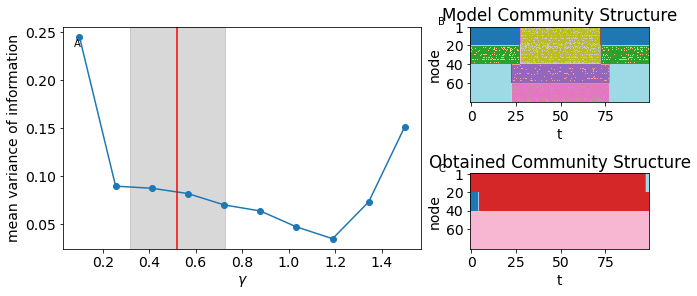

In [104]:
fig = plt.figure(constrained_layout=True,figsize=(9,4))
axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})

axs['Left'].plot(gamma_values_space,var_info_ts,marker='o')
axs['Left'].axvline(x=mean,c='r')
axs['Left'].axvspan(lower_bound, upper_bound,color='grey',alpha=0.3)
axs['Left'].set_xlabel(r'$\gamma$')
axs['Left'].set_ylabel('mean variance of information')
axs['Left'].text(0.05, 0.9, 'A', verticalalignment='bottom', 
         horizontalalignment='right', transform=axs['Left'].transAxes, fontsize=10)

axs['TopRight'].set_title('Model Community Structure')
axs['TopRight'].imshow(np.transpose(comm_structure),aspect='auto',cmap='tab20')
axs['TopRight'].set_yticks([0,19,39,59])
axs['TopRight'].set_yticklabels([1,20,40,60])
axs['TopRight'].set_xlabel('t')
axs['TopRight'].set_ylabel('node')
axs['TopRight'].text(-0.14, 1, 'B', verticalalignment='bottom', 
         horizontalalignment='right', transform=axs['TopRight'].transAxes, fontsize=10)

axs['BottomRight'].set_title('Obtained Community Structure')
axs['BottomRight'].imshow(np.transpose(comm_struct_result),aspect='auto',cmap='tab20')
axs['BottomRight'].set_yticks([19,39,59,79])
axs['BottomRight'].set_yticklabels([20,40,60,80])
axs['BottomRight'].set_xlabel('t')
axs['BottomRight'].set_ylabel('node')
axs['BottomRight'].text(-0.14, 1, 'C', verticalalignment='bottom', 
         horizontalalignment='right', transform=axs['BottomRight'].transAxes, fontsize=10)

plt.savefig('Fig_Merge.eps', format='eps')
plt.show()

In [105]:
omega_values = []
gamma_values = []
for sample in range(20):
    output_filename = 'StdMixed_search' + str(sample) + '.pck'
    with open(output_filename, 'rb') as f:
        output = pickle.load(f)
    gamma,omega = output[0][2]
    gamma_values.append(gamma)
    omega_values.append(omega)
    
gamma_values = np.array(gamma_values)
omega_values = np.array(omega_values)
mean_omega = np.mean(omega_values)

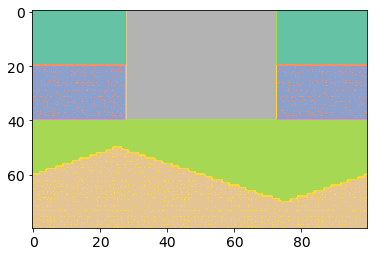

In [106]:
model = 'StdMixed'
adj_ijl, comm_structure = load_data(model)

plt.imshow(np.transpose(comm_structure),aspect='auto',cmap='Set2')
plt.show()

In [107]:
adj_matrix = adj_ijl
gamma_values_space=np.linspace(0.1,1.8,10)
parameters = [(adj_matrix, i, mean_omega) for i in gamma_values_space]
    
num_processors = 10
p=Pool(processes = num_processors)
output = p.starmap(dynamic_louvain.dynamic_louvain,parameters)
output_model.update({model: output})

In [108]:
mean, lower_bound, upper_bound = bootstrap_margins(gamma_values, 1000)
mean_gamma = mean

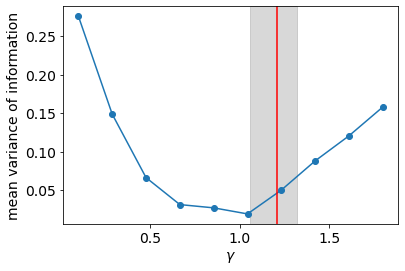

In [109]:
time_layers,_ = output[0][2].shape
var_info_ts = []
for i in range(10):
    q1 = output[i][2]
    q2 = comm_structure
    var_info = []
    for l in range(time_layers):
        var_info_aux,mutual_info = bct.partition_distance(q1[l,:], q2[l,:])
        var_info.append(var_info_aux)
    var_info_ts.append(np.mean(var_info))
plt.plot(gamma_values_space,var_info_ts,marker='o')
plt.axvline(x=mean,c='r')
plt.axvspan(lower_bound, upper_bound,color='grey',alpha=0.3)
plt.xlabel(r'$\gamma$')
plt.ylabel('mean variance of information')
plt.show()

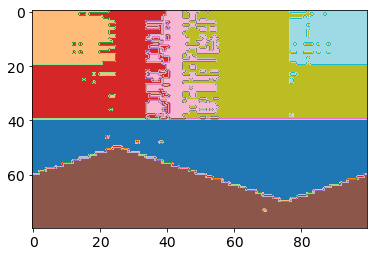

In [110]:
output = dynamic_louvain.dynamic_louvain(adj_matrix, mean_gamma, mean_omega)
comm_struct_result = output[2]
plt.imshow(np.transpose(comm_struct_result),aspect='auto',cmap='tab20')
plt.show()

In [111]:
figure_data.update({'Mixed':[gamma_values_space,var_info_ts,mean,lower_bound, upper_bound,comm_structure,comm_struct_result]})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


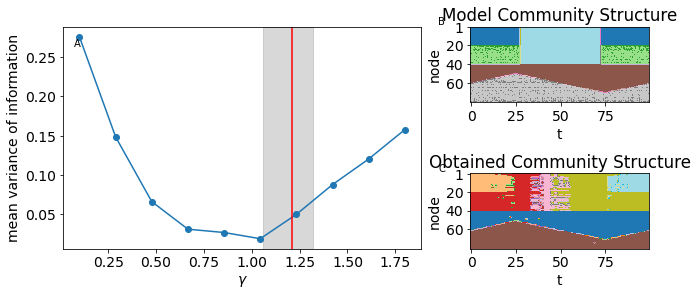

In [112]:
fig = plt.figure(constrained_layout=True,figsize=(9,4))
axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})

axs['Left'].plot(gamma_values_space,var_info_ts,marker='o')
axs['Left'].axvline(x=mean,c='r')
axs['Left'].axvspan(lower_bound, upper_bound,color='grey',alpha=0.3)
axs['Left'].set_xlabel(r'$\gamma$')
axs['Left'].set_ylabel('mean variance of information')
axs['Left'].text(0.05, 0.9, 'A', verticalalignment='bottom', 
         horizontalalignment='right', transform=axs['Left'].transAxes, fontsize=10)

axs['TopRight'].set_title('Model Community Structure')
axs['TopRight'].imshow(np.transpose(comm_structure),aspect='auto',cmap='tab20')
axs['TopRight'].set_yticks([0,19,39,59])
axs['TopRight'].set_yticklabels([1,20,40,60])
axs['TopRight'].set_xlabel('t')
axs['TopRight'].set_ylabel('node')
axs['TopRight'].text(-0.14, 1, 'B', verticalalignment='bottom', 
         horizontalalignment='right', transform=axs['TopRight'].transAxes, fontsize=10)

axs['BottomRight'].set_title('Obtained Community Structure')
axs['BottomRight'].imshow(np.transpose(comm_struct_result),aspect='auto',cmap='tab20')
axs['BottomRight'].set_yticks([0,19,39,59])
axs['BottomRight'].set_yticklabels([1,20,40,60])
axs['BottomRight'].set_xlabel('t')
axs['BottomRight'].set_ylabel('node')
axs['BottomRight'].text(-0.14, 1, 'C', verticalalignment='bottom', 
         horizontalalignment='right', transform=axs['BottomRight'].transAxes, fontsize=10)

plt.savefig('Fig_Mixed.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


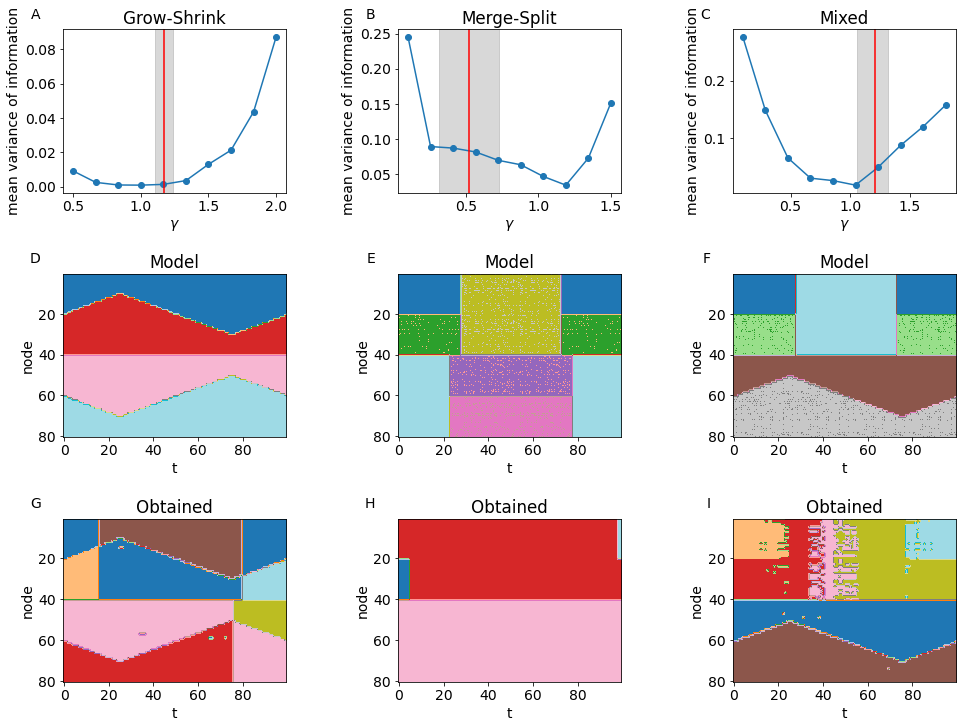

In [116]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,12))
gs = fig.add_gridspec(ncols=3, nrows=3,wspace=0.5,hspace=0.5)
#ax1 = fig.add_subplot(gs[:,0])
#ax2 = fig.add_subplot(gs[:,1])
#ax3 = fig.add_subplot(gs[:,2])

model_list=['Grow-Shrink','Merge-Split','Mixed']
panel_labels=['A','B','C']
panel_labels2=['D','E','F']
panel_labels3=['G','H','I']
for i in range(3):
    gamma_values_space,var_info_ts,mean,lower_bound,upper_bound,comm_structure,comm_struct_result = figure_data[model_list[i]]
    ax = fig.add_subplot(gs[0,i])
    ax.set_title(model_list[i])
    ax.plot(gamma_values_space,var_info_ts,marker='o')
    ax.axvline(x=mean,c='r')
    ax.axvspan(lower_bound, upper_bound,color='grey',alpha=0.3)
    ax.set_xlabel(r'$\gamma$')
    ax.set_ylabel('mean variance of information')
    ax.text(-0.1, 1.05, panel_labels[i], verticalalignment='bottom', 
             horizontalalignment='right', transform=ax.transAxes, fontsize=14)
    
    ax = fig.add_subplot(gs[1,i])
    ax.set_title('Model')
    ax.imshow(np.transpose(comm_structure),aspect='auto',cmap='tab20')
    ax.set_yticks([19,39,59,79])
    ax.set_yticklabels([20,40,60,80])
    ax.set_xlabel('t')
    ax.set_ylabel('node')
    ax.text(-0.1, 1.05, panel_labels2[i], verticalalignment='bottom', 
         horizontalalignment='right', transform=ax.transAxes, fontsize=14)
    
    ax = fig.add_subplot(gs[2,i])
    ax.set_title('Obtained')
    ax.imshow(np.transpose(comm_struct_result),aspect='auto',cmap='tab20')
    ax.set_yticks([19,39,59,79])
    ax.set_yticklabels([20,40,60,80])
    ax.set_xlabel('t')
    ax.set_ylabel('node')
    ax.text(-0.1, 1.05, panel_labels3[i], verticalalignment='bottom', 
         horizontalalignment='right', transform=ax.transAxes, fontsize=14)

plt.savefig('Benchmark_models.eps', format='eps')
plt.show()